In [1]:
# Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
# Import file rocketfuel_deciles.csv
data = pd.read_csv('/content/rocketfuel_deciles.csv')
data.head()

user_id  test  converted  tot_impr  mode_impr_day  mode_impr_hour  \
0  1391842     1          0         2              3              19   
1  1215269     1          0         1              4              12   
2  1604030     1          0         2              6              11   
3  1278452     1          0         1              7              18   
4  1363432     1          0         1              6              13   

   tot_impr_decile  
0                2  
1                1  
2                2  
3                1  
4                1

In [14]:
# Define variables and display outcomes for different questions.
outcomes_Q1 = ['tot_impr',	'mode_impr_day',	'mode_impr_hour',	'tot_impr_decile']
outcomes_Q3 = ['converted', 'tot_impr',	'mode_impr_day',	'mode_impr_hour',	'tot_impr_decile']
# outcome_Q4 = ['converted']
columns_Q1 = ['mean', 'std', 'N', 'share']
columns_Q2 = ['mean', 'ate', 'lb', 'ub', 'lift', 'N', 'share']
columns_Q4 = ['ctrl_mean', 'lift', 'ate', 'lb', 'ub', 'N']
columns_all = ['mean', 'std', 'N', 'share', 'ate', 'se_ate', 'lb', 'ub', 'lift']

In [16]:
# Q1. Check for balance:
# Compare the shares of individuals by treatment status, and the means and standard deviations of pre-experiment variables.

def basic_table(data, outcomes, display_columns):
  basic_table = data.groupby('test')[outcomes].agg(
      mean = 'mean',
      std = 'std',
      sem = 'sem',
      N = 'size'
  )

  basic_table['share'] = basic_table['N'] / len(data)

  basic_table['ate'] = basic_table['mean'] - basic_table['mean'][0]
  basic_table['se_ate'] = np.sqrt(
    basic_table['sem']**2 + basic_table['sem'][0]**2)
  basic_table['lb'] = basic_table['ate'] - 1.96*basic_table['se_ate']
  basic_table['ub'] = basic_table['ate'] + 1.96*basic_table['se_ate']
  basic_table['lift'] = basic_table['ate'] / basic_table['mean'][0]
  pd.set_option('display.width', 5000)
  return basic_table[display_columns]


for i in outcomes_Q1:
  table = basic_table(data, i, display_columns = columns_Q1)
  print('Outcome =', i)
  print(table, '\n')

Outcome = tot_impr
           mean        std       N  share
test                                     
0     24.761138  42.860720   23524   0.04
1     24.823365  43.750456  564577   0.96 

Outcome = mode_impr_day
          mean       std       N  share
test                                   
0     3.952644  1.948943   23524   0.04
1     4.028570  2.006226  564577   0.96 

Outcome = mode_impr_hour
           mean       std       N  share
test                                    
0     14.304923  4.656239   23524   0.04
1     14.475900  4.841808  564577   0.96 

Outcome = tot_impr_decile
          mean       std       N  share
test                                   
0     5.325030  2.922811   23524   0.04
1     5.453194  2.859762  564577   0.96 



In [17]:
# Q2. Plot outcome:
# Plot the means and confidence intervals of the main outcome “converted,” treatment status.

print('Table for Converted Users with :', '\n')
basic_table(data, 'converted', columns_Q2)
formula = 'converted ~ C(test)'
model = smf.ols(formula, data).fit()
model = model.get_robustcov_results(cov_type='HC3')
print(model.summary())

Table for Converted Users with : 

                            OLS Regression Results                            
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     74.94
Date:                Wed, 25 Dec 2024   Prob (F-statistic):           4.86e-18
Time:                        07:40:45   Log-Likelihood:             2.5499e+05
No. Observations:              588101   AIC:                        -5.100e+05
Df Residuals:                  588099   BIC:                        -5.099e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    

In [18]:
table = data.groupby('test')['converted'].agg(
    mean = 'mean',
    std  = 'std',
    N   = 'count'
)
table['mean']
table['se'] = table['std']/np.sqrt(table['N'])
table['lb'] = table['mean'] - 1.96*table['se']
table['ub'] = table['mean'] + 1.96*table['se']

print('Means and confidence intervals for converted')
print(table[['mean', 'lb','ub']])



plt.errorbar(table.index, table['mean'], yerr=(table['ub'] - table['mean']), fmt='o')


plt.legend()
plt.ylabel("ATE on Conversion")
plt.xlabel('Treatment Status')
plt.xticks([0,1], ['Control', 'Treatment'])
plt.title("Treatment effects on Conversion")
plt.show()

'''
plt.figure()
plt.errorbar(table.index, table['ate'], yerr = table['error_bar'], fmt='o')

plt.legend()
plt.ylabel("ATE on Conversion")
plt.xlabel('Treatment Status')
plt.xticks([0,1], ['Control', 'Treatment'])
plt.title("Treatment effects on Conversion")
plt.show()'''

Means and confidence intervals for converted
          mean        lb        ub
test                              
0     0.017854  0.016162  0.019546
1     0.025547  0.025135  0.025958


'\nplt.figure()\nplt.errorbar(table.index, table[\'ate\'], yerr = table[\'error_bar\'], fmt=\'o\')\n\nplt.legend()\nplt.ylabel("ATE on Conversion")\nplt.xlabel(\'Treatment Status\')\nplt.xticks([0,1], [\'Control\', \'Treatment\'])\nplt.title("Treatment effects on Conversion")\nplt.show()'

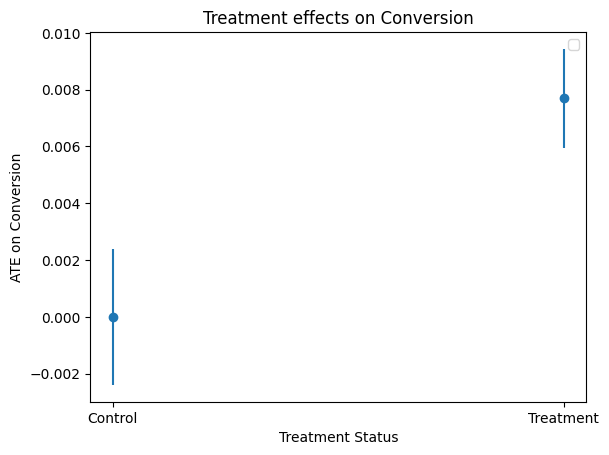

In [19]:
# Q2. Plot outcome:
# Plot the means and confidence intervals of the main outcome “converted,” treatment status.

basic_table_converted = basic_table(data, 'converted', columns_all)
err_converted = 1.96 * basic_table_converted['se_ate']

plt.figure()
plt.errorbar(basic_table_converted.index, basic_table_converted['ate'], yerr = err_converted, fmt='o')

plt.legend()
plt.ylabel("ATE on Conversion")
plt.xlabel('Treatment Status')
plt.xticks([0,1], ['Control', 'Treatment'])
plt.title("Treatment effects on Conversion")
plt.show()

In [20]:
# Q3. Find ATE:
# Estimate of the Average Treatment Effect (ATE) of the ads for treatment relative to control.
# The associated standard error, and the 95% confidence interval on the Average Treatment Effects.
for i in outcomes_Q3:
  table = basic_table(data, i, display_columns = columns_all)
  print('Outcome =', i)
  print(table, '\n')

Outcome = converted
          mean       std       N  share       ate    se_ate        lb        ub      lift
test                                                                                     
0     0.017854  0.132424   23524   0.04  0.000000  0.001221 -0.002393  0.002393  0.000000
1     0.025547  0.157778  564577   0.96  0.007692  0.000889  0.005951  0.009434  0.430851 

Outcome = tot_impr
           mean        std       N  share       ate    se_ate        lb        ub      lift
test                                                                                       
0     24.761138  42.860720   23524   0.04  0.000000  0.395202 -0.774595  0.774595  0.000000
1     24.823365  43.750456  564577   0.96  0.062228  0.285451 -0.497257  0.621712  0.002513 

Outcome = mode_impr_day
          mean       std       N  share       ate    se_ate        lb        ub      lift
test                                                                                     
0     3.952644  1.948943 

In [22]:
# Q4. Subgroup analysis:
# Create a summary table showing the treatment effect in each decile.
# Indicating the decile, control mean, HTE, lift, and 95% CI for the HTE.

def basic_table_subgroup(data_in, group_var, var):
  sub = data_in.groupby(group_var)[var].agg(
      mean = 'mean',
      std = 'std',
      N = 'size')
  sub['ate'] = sub['mean'] - sub['mean'][0]
  sub['lift'] = sub['ate'] / sub['mean'][0]
  sub['se'] = sub['std'] / np.sqrt(sub['N'])
  sub['se_ate'] = np.sqrt(sub['se']**2 + sub['se'][0]**2)
  sub['lb'] = sub['ate'] - 1.96*sub['se_ate']
  sub['ub'] = sub['ate'] + 1.96*sub['se_ate']
  sub['ctrl_mean'] = sub['mean'][0]
  # The the same ctrl_mean value for both test = 0 and 1,
  # due to ctrl_mean is assigned in the basic_table_subgroup function.
  # The correct table is shown downbelow.
  return sub

for tot_impr_decile in range(1,11):
  subdata = data[data['tot_impr_decile'] == tot_impr_decile]
  sub_table = basic_table_subgroup(subdata, 'test', 'converted')
  print('Decile =', tot_impr_decile)
  print(sub_table[columns_Q4], '\n')

Decile = 1
      ctrl_mean     lift       ate        lb        ub      N
test                                                         
0        0.0013  0.00000  0.000000 -0.002079  0.002079   2308
1        0.0013  0.21851  0.000284 -0.001224  0.001792  54298 

Decile = 2
      ctrl_mean      lift       ate        lb        ub      N
test                                                          
0      0.002155  0.000000  0.000000 -0.002255  0.002255   3249
1      0.002155  0.195236  0.000421 -0.001221  0.002062  65239 

Decile = 3
      ctrl_mean      lift       ate        lb        ub      N
test                                                          
0      0.005208  0.000000  0.000000 -0.004158  0.004158   2304
1      0.005208 -0.341279 -0.001777 -0.004761  0.001206  50425 

Decile = 4
      ctrl_mean      lift       ate        lb        ub      N
test                                                          
0      0.005622  0.000000  0.000000 -0.004154  0.004154   2490
1      0.

In [25]:
def correct_table(data, group_vars, outcome_var):
  dt = data.groupby(['tot_impr_decile', 'test'])['converted'].agg(
        mean = 'mean',
        std = 'std',
        N = 'size')
  dt['se'] = dt['std'] / np.sqrt(dt['N'])
  dt['lb'] = dt['mean'] - 1.96 * dt['se']
  dt['ub'] = dt['mean'] + 1.96 * dt['se']
  return dt

result = correct_table(data, ['tot_impr_decile', 'test'], 'converted')
print(result)

                          mean       std      N        se        lb        ub
tot_impr_decile test                                                         
1               0     0.001300  0.036037   2308  0.000750 -0.000170  0.002770
                1     0.001584  0.039766  54298  0.000171  0.001249  0.001918
2               0     0.002155  0.046374   3249  0.000814  0.000560  0.003749
                1     0.002575  0.050681  65239  0.000198  0.002186  0.002964
3               0     0.005208  0.071996   2304  0.001500  0.002268  0.008148
                1     0.003431  0.058473  50425  0.000260  0.002920  0.003941
4               0     0.005622  0.074787   2490  0.001499  0.002685  0.008560
                1     0.004210  0.064752  56051  0.000274  0.003674  0.004747
5               0     0.006667  0.081395   2250  0.001716  0.003303  0.010030
                1     0.006833  0.082379  60882  0.000334  0.006179  0.007487
6               0     0.008074  0.089517   1734  0.002150  0.003

<ipython-input-26-a87ebc80056b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_data['ci'] = (control_data['ub'] - control_data['lb']) / 2
<ipython-input-26-a87ebc80056b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment_data['ci'] = (treatment_data['ub'] - treatment_data['lb']) / 2


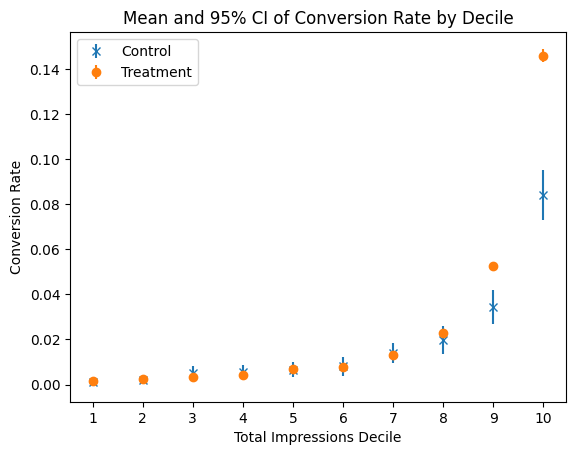

In [26]:
# Q5. Subgroup plots – means + CI:
# Create a graph that shows the mean and 95% CI on “converted” separately for treatment and control plotted over the 10 deciles of total impressions.

table = correct_table(data, ['tot_impr_decile', 'test'], 'converted')

table = table.reset_index()
# Separate control and treatment data
control_data = table[table['test'] == 0]
treatment_data = table[table['test'] == 1]

control_data['ci'] = (control_data['ub'] - control_data['lb']) / 2
treatment_data['ci'] = (treatment_data['ub'] - treatment_data['lb']) / 2

# Plotting
plt.figure()

# Plot control group with error bars
plt.errorbar(control_data['tot_impr_decile'], control_data['mean'], yerr=control_data['ci'],
             fmt='x', label='Control')

# Plot treatment group with error bars
plt.errorbar(treatment_data['tot_impr_decile'], treatment_data['mean'], yerr=treatment_data['ci'],
             fmt='o', label='Treatment')

# Add plot details
plt.legend()
plt.title("Mean and 95% CI of Conversion Rate by Decile")
plt.xlabel('Total Impressions Decile')
plt.ylabel('Conversion Rate')
plt.xticks(range(1, 11))

plt.show()

In [27]:
control_data = table[table['test'] == 0]
treatment_data = table[table['test'] == 1]

# Calculate confidence intervals for each group
control_data['ci'] = 1.96 * control_data['se']
treatment_data['ci'] = 1.96 * treatment_data['se']

# Plot mean conversion rates with confidence intervals for control and treatment groups
plt.figure()
plt.errorbar(control_data['tot_impr_decile'], control_data['mean'],
             yerr=control_data['ci'], fmt='x', label='control', ecolor='orange', color='orange')
plt.errorbar(treatment_data['tot_impr_decile'], treatment_data['mean'],
             yerr=treatment_data['ci'], fmt='o', label='treatment', ecolor='blue', color='blue')

# Add labels and legend
plt.legend()
plt.title("ate and confidence level by decile")
plt.xlabel("Treatment arm decile")
plt.ylabel("ate")
plt.xticks(range(1, 11))  # Assuming deciles 1 through 10
plt.show()

<ipython-input-27-6770474d694c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_data['ci'] = 1.96 * control_data['se']
<ipython-input-27-6770474d694c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment_data['ci'] = 1.96 * treatment_data['se']


In [28]:
# Q6. Calculate the return on advertising:
# The return on advertising spending is the extra profit generated from that spending, divided by the cost of spending.
# What is the overall return on advertising spending?
# (Note: you will need to use information from the case to determine markup per sale.)

total_impressions = 14500000
cpm = 9
total_purchase = 15000
markup_per_sale = 40
Total_Ad_Spending = 14500000 * 9 / 1000
Number_of_Users = 564577
ad_spending_per_person_treatment = Total_Ad_Spending / Number_of_Users

mean_conversion_treatment = data[data['test'] == 1]['converted'].mean()
mean_conversion_control = data[data['test'] == 0]['converted'].mean()

ATE_conversions = mean_conversion_treatment - mean_conversion_control

# Calculate Return on Advertising
ROA = (ATE_conversions * markup_per_sale) / ad_spending_per_person_treatment
total_ROA = ROA.sum()
print("Total Return on Advertising (ROA):", ROA)

# ROA = Extra Profit / Ad Spending = (ATE on Conversion * Markup) / (Price per impression) * Impressions
# Mistake 1: Use convert instead of ATE
# Mistake 2: Use control group ad costs

Total Return on Advertising (ROA): 1.3311822669405535


In [29]:
# Q7. Targeting:
# Now suppose you could target ads, based on deciles of impression
# (so you can control which decile is included in the campaign, but the total impression and costs will differ by decile).
# If you targeted only the deciles with positive return, how much higher would your return be?
# (Hint: you may need to calculate the return on advertising spending in each decile.)
cpm = 9
markup_per_sale = 40
mean_conversion_control = data[data['test'] == 0]['converted'].mean()
treatment_data = data[data['test'] == 1]

for decile in range(1, 11):
    subdata = treatment_data[treatment_data['tot_impr_decile'] == decile]

    if 'converted' not in subdata.columns:
        print(f"'converted' column is missing in decile {decile}. Please check your data.")
        continue

    mean_conversion_decile = subdata['converted'].mean()
    ATE_conversions_decile = mean_conversion_decile - mean_conversion_control
    total_impressions_decile = subdata['tot_impr'].sum()
    ad_spending_per_person_decile = (cpm / 1000) * (total_impressions_decile / len(subdata))

    decile_ROA = (ATE_conversions_decile * markup_per_sale) / ad_spending_per_person_decile
    print("Decile:", decile, "ROA:", decile_ROA)

total_ROA = 0.7598891419786106 + 3.539473814133693 + 4.807145425731553
print(total_ROA)

Decile: 1 ROA: -72.31224163955261
Decile: 2 ROA: -28.07340237257776
Decile: 3 ROA: -14.070862183664197
Decile: 4 ROA: -8.81992619103261
Decile: 5 ROA: -4.434562141886945
Decile: 6 ROA: -2.877967792860342
Decile: 7 ROA: -1.0470717959480158
Decile: 8 ROA: 0.7598891419786106
Decile: 9 ROA: 3.539473814133693
Decile: 10 ROA: 4.807145425731553
9.106508381843856
